# Sezione 1: Configurazione dell'Ambiente
Importa le librerie necessarie e assicurati che TensorFlow utilizzi la GPU.

In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-11 22:33:51.532108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 22:33:51.678822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736631231.741709      68 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736631231.762801      68 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 22:33:51.904067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Sezione 2: Percorsi e Parametri
Configura i percorsi per il dataset e i parametri necessari.

In [2]:
# Dataset path in WSL2 (accessing Windows directory)
DATASET_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

# Parameters
SAMPLE_RATE = 16000   # Audio sample rate
DURATION = 5          # Duration of audio clips in seconds
N_MELS = 128          # Number of Mel frequency bins
MAX_TIME_STEPS = 109  # Maximum number of time steps (calculated empirically)

# Sezione 3: Caricamento ed Etichettatura dei Dati
Carica i file audio e genera Mel-spectrogram, associando le etichette.

In [3]:
from tqdm import tqdm  # Libreria per la barra di avanzamento

# Load labels
labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

# Preprocess data
X = []
y = []

# Counter with tqdm for monitoring
print("Loading and processing data...")
for file_name, label in tqdm(labels.items(), desc="Processing files"):
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio and generate Mel-spectrogram
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncation to ensure uniform time steps
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X.append(mel_spectrogram)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Finished loading {len(X)} samples.")


Loading and processing data...


Processing files: 100%|███████████████████████████████████████████████████████████| 25380/25380 [08:09<00:00, 51.80it/s]


Finished loading 25380 samples.


# Sezione 4: Creazione del Modello CNN
Definisci il modello CNN per la classificazione.

In [4]:
# Define the CNN model
input_layer = Input(shape=(N_MELS, MAX_TIME_STEPS, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1736549460.209055     135 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5523 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 109, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 109, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 54, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,096,961 (27.07 MB)

 Trainable params: 7,096,961 (27.07 MB)

 Non-trainable params: 0 (0.00 B)

# Sezione 5: Training del Modello
Esegui il training utilizzando i dati preprocessati. Usa tf.data per ottimizzare i dati per GPU.

In [5]:
# Reshape data for CNN (add channel dimension)
X = X[..., np.newaxis]

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1736549476.466527     284 service.cc:148] XLA service 0x7f5f3c009f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736549476.466610     284 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-10 23:51:16.493004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736549476.633647     284 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/635 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7831 - loss: 44.1466

I0000 00:00:1736549478.264796     284 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


635/635 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8954 - loss: 3.5972 - val_accuracy: 0.9797 - val_loss: 0.0509
Epoch 2/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9782 - loss: 0.0614 - val_accuracy: 0.9882 - val_loss: 0.0359
Epoch 3/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9863 - loss: 0.0393 - val_accuracy: 0.9937 - val_loss: 0.0196
Epoch 4/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9937 - loss: 0.0205 - val_accuracy: 0.9923 - val_loss: 0.0254
Epoch 5/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9934 - loss: 0.0192 - val_accuracy: 0.9923 - val_loss: 0.0296
Epoch 6/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9932 - loss: 0.0174 - val_accuracy: 0.9925 - val_loss: 0.0239
Epoch 7/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.9909 - val_loss: 0.0383
Epoch 8/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.99

# Sezione 6: Valutazione
Valuta il modello e salva i risultati.

In [6]:
# Evaluate on training and validation sets
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model
model.save("deepfake_detector_model.h5")

635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.4593e-04
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0164


Training Loss: 9.965148638002574e-05, Training Accuracy: 1.0
Validation Loss: 0.010537705384194851, Validation Accuracy: 0.997438907623291


# Sezione 7: Visualizzazione degli Spettrogrammi Mel
Visualizziamo uno spettrogramma Mel per ogni classe.

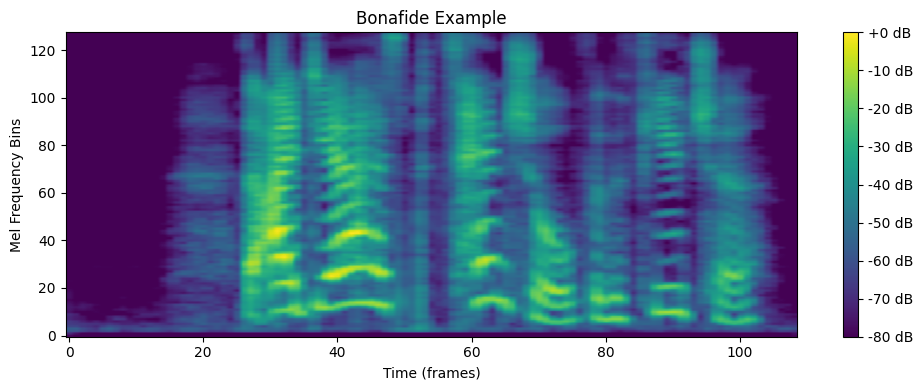

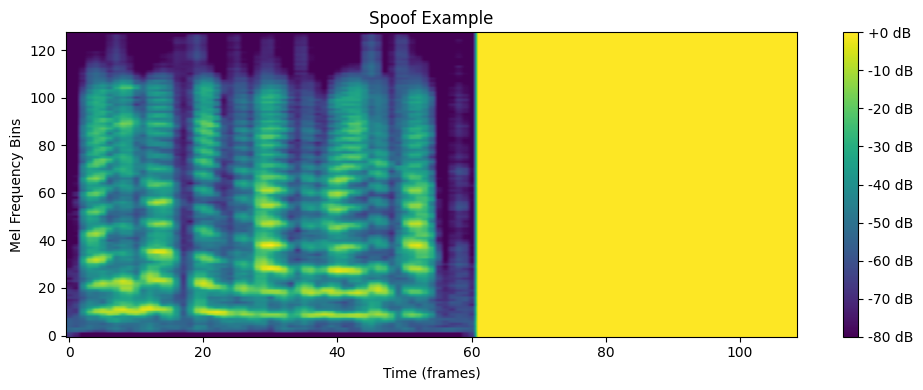

In [8]:
import matplotlib.pyplot as plt

# Function to plot a Mel-spectrogram
def plot_mel_spectrogram(mel_spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel Frequency Bins')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Select a bonafide sample
for i, label in enumerate(y):
    if label == 1:  # Bonafide class
        plot_mel_spectrogram(X[i, :, :, 0], "Bonafide Example")
        break

# Select a spoof sample
for i, label in enumerate(y):
    if label == 0:  # Spoof class
        plot_mel_spectrogram(X[i, :, :, 0], "Spoof Example")
        break

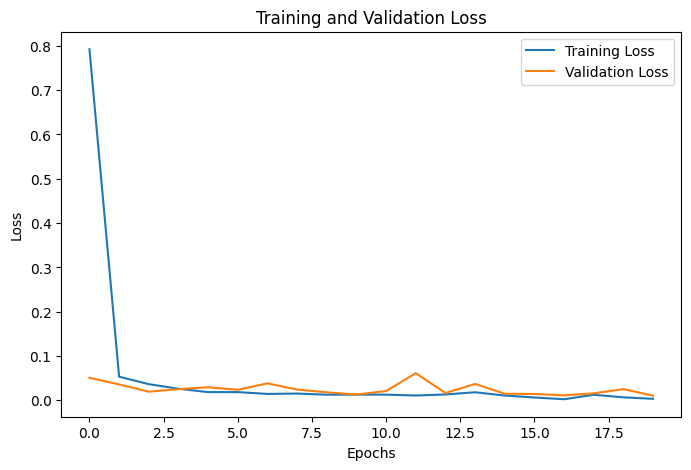

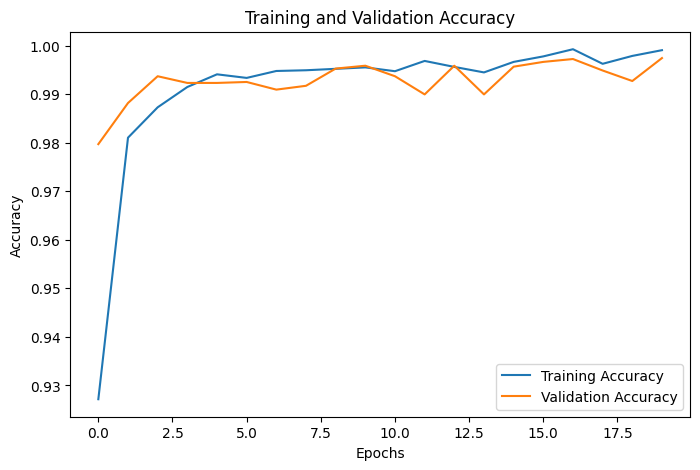

In [9]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Sezione 8: Calcolo dell'Errore di Generalizzazione con il Set di Test

In [11]:
import random

# Path to the test set and protocol file
TEST_DATASET_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_eval/flac"
TEST_LABEL_FILE_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

# Input per ridurre il numero di campioni
num_samples = int(input("Enter the number of samples to load from the test set (max 70000): "))

# Load test labels
test_labels = {}
with open(TEST_LABEL_FILE_PATH, 'r') as test_label_file:
    lines = test_label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    test_labels[file_name] = label

# Selezione casuale di campioni
selected_files = random.sample(list(test_labels.keys()), min(num_samples, len(test_labels)))

# Preprocess test data
X_test = []
y_test = []

print("Loading and processing test data...")
for file_name in tqdm(selected_files, desc="Processing test files"):
    file_path = os.path.join(TEST_DATASET_PATH, file_name + ".flac")
    label = test_labels[file_name]

    # Load audio and generate Mel-spectrogram
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncation to ensure uniform time steps
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)
    y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape for CNN input
X_test = X_test[..., np.newaxis]

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate generalization error
train_accuracy = history.history['accuracy'][-1]
generalization_error = train_accuracy - test_accuracy
print(f"Generalization Error: {generalization_error}")


Enter the number of samples to load from the test set (max 70000):  2500


Loading and processing test data...


Processing test files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:32<00:00, 76.16it/s]


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8838 - loss: 0.9010
Test Loss: 0.9096200466156006, Test Accuracy: 0.8820000290870667
Generalization Error: 0.11706417798995972
